In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import xgboost as xgb
from xgboost import XGBClassifier

In [72]:
train = pd.read_csv('TitanicDataset/train.csv')
test = pd.read_csv('TitanicDataset/test.csv')

In [73]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [74]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [75]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [76]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [77]:
train.isnull().mean() * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [78]:
train.duplicated().sum()

0

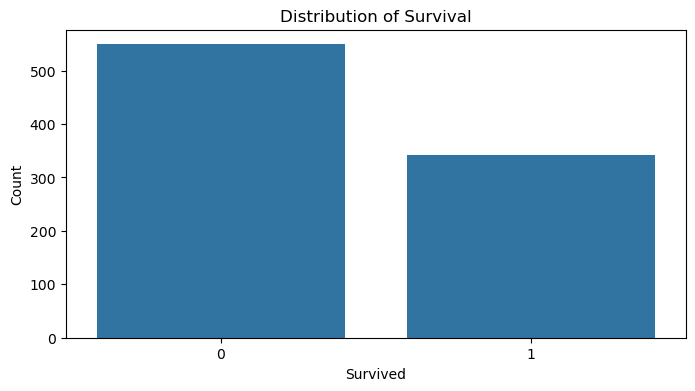

In [79]:
plt.figure(figsize=(8,4))
sns.countplot(x='Survived', data=train)
plt.title("Distribution of Survival")
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

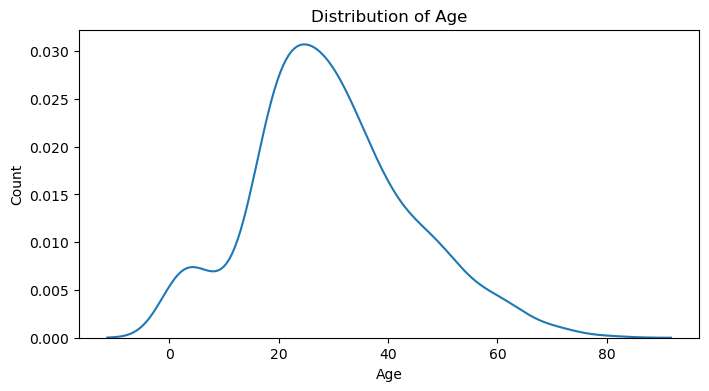

In [80]:
plt.figure(figsize=(8,4))
sns.kdeplot(x='Age', data=train)
plt.title("Distribution of Age")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

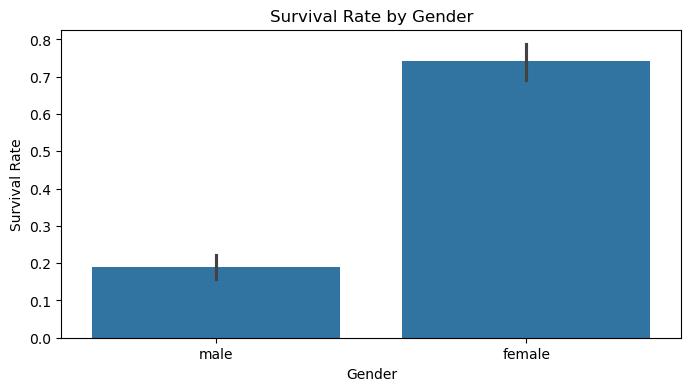

In [81]:
plt.figure(figsize=(8,4))
sns.barplot(x='Sex', y='Survived', data=train)
plt.title("Survival Rate by Gender")
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.show()

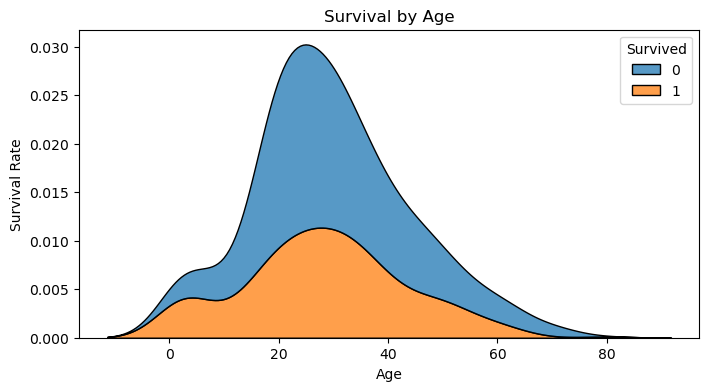

In [82]:
plt.figure(figsize=(8,4))
sns.kdeplot(x='Age', hue='Survived', data=train, multiple='stack')
plt.title("Survival by Age")
plt.xlabel('Age')
plt.ylabel('Survival Rate')
plt.show()

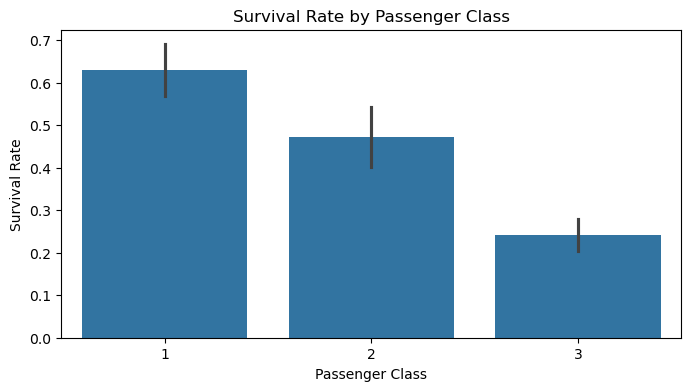

In [83]:
plt.figure(figsize=(8,4))
sns.barplot(x='Pclass', y='Survived', data=train)
plt.title("Survival Rate by Passenger Class")
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate')
plt.show()

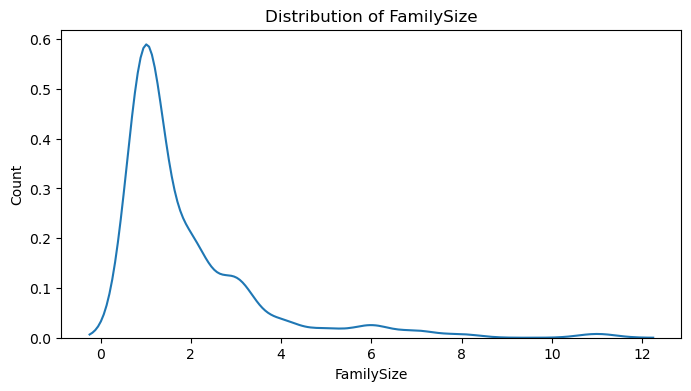

In [84]:
#Creating FamilySize variable that includes the passenger themselves
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

plt.figure(figsize=(8,4))
sns.kdeplot(x='FamilySize', data=train)
plt.title('Distribution of FamilySize')
plt.xlabel('FamilySize')
plt.ylabel('Count')
plt.show()

<Axes: >

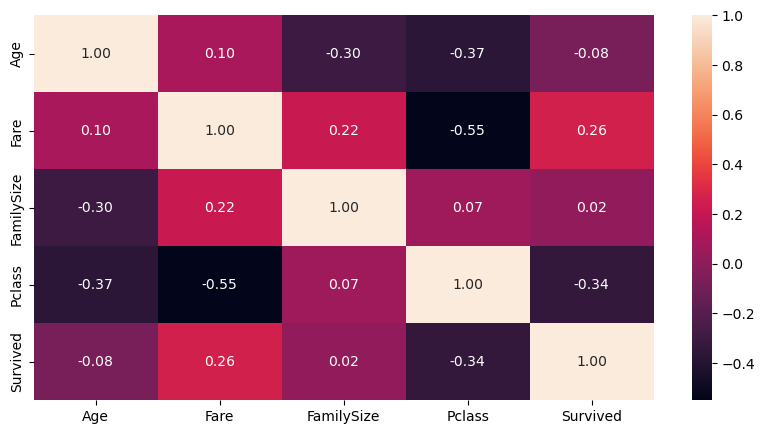

In [85]:
plt.figure(figsize=(10,5))
corr = train[['Age', 'Fare', 'FamilySize', 'Pclass', 'Survived']].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

In [86]:
def process_family_size(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).map({True: 'Y', False: 'N'})
    df['FamilyGroup'] = pd.cut(df['FamilySize'], bins=[0,1,4,7,20], labels=['Alone', 'Small', 'Medium', 'Large'])
    return df

train = process_family_size(train)
test = process_family_size(test)

In [87]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

def process_titles(df):
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
    df['Title'] = df['Title'].replace(['Capt', 'Col' , 'Major', 'Dr', 'Rev', 'Dona', 'Jonkheer', 'Don'], 'Other')
    return df

train = process_titles(train)
test = process_titles(test)

In [88]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone,FamilyGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,N,Small,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,N,Small,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,Y,Alone,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,N,Small,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,Y,Alone,Mr


In [89]:
#Drop unnecessary columns
X = train.drop(['Survived', 'Cabin', 'PassengerId', 'Name', 'Ticket','FamilySize'], axis=1)
X_test = test.drop(['Cabin', 'PassengerId', 'Name', 'Ticket','FamilySize'], axis=1)
y = train['Survived']

In [90]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,FamilyGroup,Title
0,3,male,22.0,1,0,7.2500,S,N,Small,Mr
1,1,female,38.0,1,0,71.2833,C,N,Small,Mrs
2,3,female,26.0,0,0,7.9250,S,Y,Alone,Miss
3,1,female,35.0,1,0,53.1000,S,N,Small,Mrs
4,3,male,35.0,0,0,8.0500,S,Y,Alone,Mr


In [91]:
numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', ]
categorical_features = ['Sex', 'Embarked', 'IsAlone', 'Title', 'FamilyGroup','Pclass']

In [92]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [93]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,IsAlone,FamilyGroup,Title
266,3,male,16.0,4,1,39.6875,S,N,Medium,Mr
582,2,male,54.0,0,0,26.0000,S,Y,Alone,Mr
706,2,female,45.0,0,0,13.5000,S,Y,Alone,Mrs
132,3,female,47.0,1,0,14.5000,S,N,Small,Mrs
815,1,male,NaN,0,0,0.0000,S,Y,Alone,Mr


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [95]:
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=99),
    'Support Vector Machine': SVC(probability=True, random_state=99),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=99),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=99),
    'XGBoost': XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.10, subsample=0.8, colsample_bytree=0.8, random_state=99, eval_metric='logloss')
}

In [96]:
# Train and evaluate models
results = {}
for name, clf in classifiers.items():
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, model_pipeline.predict_proba(X_val)[:,1])
    results[name] = {"Accuracy": accuracy, "ROC AUC": roc_auc}

In [97]:
results_df = pd.DataFrame(results).T
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                        Accuracy   ROC AUC
Logistic Regression     0.804469  0.840574
Random Forest           0.837989  0.847144
Support Vector Machine  0.798883  0.846608
K-Nearest Neighbors     0.815642  0.838496
Decision Tree           0.815642  0.828707
Gradient Boosting       0.837989  0.853647
XGBoost                 0.843575  0.882140


In [98]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=300, max_depth=5, learning_rate=0.10, subsample=0.8,
                                 colsample_bytree=0.8, random_state=99, eval_metric='logloss'))
     ])


In [99]:
xgb_pipeline.fit(X, y)
y_pred = xgb_pipeline.predict(X_test)

In [129]:
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': y_pred
})

submission.to_csv('submission.csv', index=False)